In [1]:
module VREP

export simx_start,
    simx_finish,
    simx_get_object_handle,
    simx_get_string_signal,
    simx_unpack_floats,
    simx_get_vision_sensor_image,
    simx_get_object_position,
    simx_get_object_orientation,
    simx_set_joint_target_velocity,
    simx_start_simulation,
    simx_stop_simulation,
    simx_opmode_oneshot,
    simx_opmode_oneshot_wait,
    simx_opmode_streaming,
    simx_opmode_buffer,
    simx_return_ok


const simx_opmode_oneshot      = 0x000000
const simx_opmode_oneshot_wait = 0x010000
const simx_opmode_streaming    = 0x020000
const simx_opmode_buffer       = 0x060000

const simx_return_ok = 0x000000


import Libdl

const lib = Libdl.dlopen("./remoteApi.so")
const simx_start_fn = Libdl.dlsym(lib, :simxStart)
const simx_finish_fn = Libdl.dlsym(lib, :simxFinish)
const simx_get_object_handle_fn = Libdl.dlsym(lib, :simxGetObjectHandle)
const simx_read_proximity_sensor_fn = Libdl.dlsym(lib, :simxReadProximitySensor)
const simx_get_string_signal_fn = Libdl.dlsym(lib, :simxGetStringSignal)
const simx_get_vision_sensor_image_fn = Libdl.dlsym(lib, :simxGetVisionSensorImage)
const simx_get_object_position_fn = Libdl.dlsym(lib, :simxGetObjectPosition)
const simx_get_object_orientation_fn = Libdl.dlsym(lib, :simxGetObjectOrientation)
const simx_set_joint_target_velocity_fn = Libdl.dlsym(lib, :simxSetJointTargetVelocity)
const simx_start_simulation_fn = Libdl.dlsym(lib, :simxStartSimulation)
const simx_stop_simulation_fn = Libdl.dlsym(lib, :simxStopSimulation)

function simx_start(connection_address, connection_port, wait_until_connected,
                    do_dot_reconnect_once_disconnected, timeout_in_ms, comm_thread_cycle_in_ms)
    client_id = ccall(simx_start_fn,
        Cint, (Cstring, Cint, Cuchar, Cuchar, Cint, Cint),
        connection_address, connection_port, wait_until_connected,
        do_dot_reconnect_once_disconnected, timeout_in_ms, comm_thread_cycle_in_ms)
    return client_id
end

function simx_finish(client_id)
    ccall(simx_finish_fn,
        Cvoid, (Cint,),
        client_id)
    return nothing
end

function simx_get_object_handle(client_id, object_name, operation_mode)
    handle = Ref{Cint}(0)
    ret = ccall(simx_get_object_handle_fn,
        Cint, (Cint, Cstring, Ref{Cint}, Cint),
        client_id, object_name, handle, operation_mode)
    return ret, handle[]
end

function simx_read_proximity_sensor(client_id, sensor_handle, operation_mode)
    detection_state = Ref{Cuchar}(0)
    detected_object_handle = Ref{Cint}(0)
    detected_point = Vector{Cfloat}(undef, 3)
    detected_surface_normal_vector = Vector{Cfloat}(undef, 3)
    ret = ccall(simx_read_proximity_sensor_fn,
        Cint, (Cint, Cint, Ref{Cuchar}, Ref{Cfloat}, Ref{Cint}, Ref{Cfloat}, Cint),
        client_id, sensor_handle, detection_state, detected_point, detected_object_handle,
        detected_surface_normal_vector, operation_mode)
    return ret, detection_state[] != 0, detected_point, detected_object_handle[], detected_surface_normal_vector
end

function simx_get_string_signal(client_id, signal_name, operation_mode)
    signal_length = Ref{Cint}(0)
    signal_value = Ref{Ptr{Cuchar}}()
    ret = ccall(simx_get_string_signal_fn,
        Cint, (Cint, Cstring, Ref{Ptr{Cuchar}}, Ref{Cint}, Cint),
        client_id, signal_name, signal_value, signal_length, operation_mode)
    signal_str = unsafe_string(signal_value[], signal_length[])
    return ret, signal_str
end

function simx_unpack_floats(floats_packed_in_string)
    v = Vector{Float32}(undef, 0)
    data = Vector{UInt8}(floats_packed_in_string)
    for i=1:4:length(data)
        n = reinterpret(Float32, data[i:i+3])[1]
        push!(v, n)
    end
    return v
end

function simx_get_vision_sensor_image(client_id, sensor_handle, options, operation_mode)
    resolution = Vector{Cint}(undef, 2)
    image_raw = Ref{Ptr{Cuchar}}()
    bytes_per_pixel = 3
    if (options & 1) != 0
        bytes_per_pixel = 1
    end
    ret = ccall(simx_get_vision_sensor_image_fn,
        Cint, (Cint, Cint, Ref{Cint}, Ref{Ptr{Cuchar}}, Cuchar, Cint),
        client_id, sensor_handle, resolution, image_raw, options, operation_mode)
    if ret != simx_return_ok
        return ret, resolution, Vector{UInt8}(undef, 0)
    end
    image_data = Vector{UInt8}(undef, resolution[1] * resolution[2] * bytes_per_pixel)
    for i=1:length(image_data)
        image_data[i] = unsafe_load(image_raw[], i)
    end
    return ret, resolution, image_data
end

function simx_get_object_position(client_id, object_handle, relative_to_object_handle, operation_mode)
    position = Vector{Cfloat}(undef, 3)
    ret = ccall(simx_get_object_position_fn,
        Cint, (Cint, Cint, Cint, Ref{Cfloat}, Cint),
        client_id, object_handle, relative_to_object_handle, position, operation_mode)
    return ret, position
end

function simx_get_object_orientation(client_id, object_handle, relative_to_object_handle, operation_mode)
    euler_angles = Vector{Cfloat}(undef, 3)
    ret = ccall(simx_get_object_orientation_fn,
        Cint, (Cint, Cint, Cint, Ref{Cfloat}, Cint),
        client_id, object_handle, relative_to_object_handle, euler_angles, operation_mode)
    return ret, euler_angles
end

function simx_set_joint_target_velocity(client_id, joint_handle, target_velocity, operation_mode)
    ret = ccall(simx_set_joint_target_velocity_fn,
        Cint, (Cint, Cint, Cfloat, Cint),
        client_id, joint_handle, target_velocity, operation_mode)
    return ret
end

function simx_start_simulation(client_id, operation_mode)
    ret = ccall(simx_start_simulation_fn,
        Cint, (Cint, Cint),
        client_id, operation_mode)
    return ret
end

function simx_stop_simulation(client_id, operation_mode)
    ret = ccall(simx_stop_simulation_fn,
        Cint, (Cint, Cint),
        client_id, operation_mode)
    return ret
end

end # module VREP

Main.VREP

In [2]:
function start_sim(connection_address, connection_port)
    VREP.simx_finish(-1)
    client_id = VREP.simx_start(connection_address, connection_port, true, true, 2000, 5)
    if client_id != -1
        println("Connected to remoteApi server.")
    else
        VREP.simx_finish(-1)
        error("Unable to connect to remoteApi server. Consider running scene before executing script.")
    end
    return client_id
end

function start_sensors(client_id)
    # Starting ultrasonic sensors
    sonar_handle = Vector{Int32}(undef, 16)
    for i=1:16
        sensor_name = string("Pioneer_p3dx_ultrasonicSensor", i)

        res, handle = VREP.simx_get_object_handle(client_id, sensor_name, VREP.simx_opmode_oneshot_wait)
        if res != VREP.simx_return_ok
            println(sensor_name, " not connected.")
        else
            println(sensor_name, " connected.")
            sonar_handle[i] = handle
        end
    end

    #Starting vision sensor
    res, vision_handle = VREP.simx_get_object_handle(client_id, "Vision_sensor", VREP.simx_opmode_oneshot_wait)
    if res != VREP.simx_return_ok
        println("Vision sensor not connected.")
    else
        println("Vision sensor connected.")
    end
    
    #Starting laser sensor
    res, laser_handle = VREP.simx_get_object_handle(client_id, "fastHokuyo", VREP.simx_opmode_oneshot_wait)
    if res != VREP.simx_return_ok
        println("Laser not connected.")
    else
        println("Laser connected.")
    end
    
    return sonar_handle, vision_handle, laser_handle
end

function start_motors(client_id)
    res, left_handle = VREP.simx_get_object_handle(client_id, "Pioneer_p3dx_leftMotor", VREP.simx_opmode_oneshot_wait)
    if res != VREP.simx_return_ok
        println("Left motor not connected.")
    else
        println("Left motor connected.")
    end
    
    res, right_handle = VREP.simx_get_object_handle(client_id, "Pioneer_p3dx_rightMotor", VREP.simx_opmode_oneshot_wait)
    if res != VREP.simx_return_ok
        println("Right motor not connected.")
    else
        println("Right motor connected.")
    end
    
    return Dict(:left => left_handle, :right => right_handle)
end

function start_robot(client_id)
    res, robot_handle = VREP.simx_get_object_handle(client_id, "Pioneer_p3dx", VREP.simx_opmode_oneshot_wait)
    if res != VREP.simx_return_ok
        println("Robot not connected.")
    else
        println("Robot connected.")
    end
    
    return robot_handle
end


client_id = start_sim("127.0.0.1", 25000)

@show(client_id)

sonar_handle, vision_handle, laser_handle = start_sensors(client_id)

@show(sonar_handle)

@show(vision_handle)

@show(laser_handle)

motors_handle = start_motors(client_id)

@show(motors_handle)

robot_handle = start_robot(client_id)

@show(robot_handle)

nothing

Connected to remoteApi server.
client_id = 0
Pioneer_p3dx_ultrasonicSensor1 connected.
Pioneer_p3dx_ultrasonicSensor2 connected.
Pioneer_p3dx_ultrasonicSensor3 connected.
Pioneer_p3dx_ultrasonicSensor4 connected.
Pioneer_p3dx_ultrasonicSensor5 connected.
Pioneer_p3dx_ultrasonicSensor6 connected.
Pioneer_p3dx_ultrasonicSensor7 connected.
Pioneer_p3dx_ultrasonicSensor8 connected.
Pioneer_p3dx_ultrasonicSensor9 connected.
Pioneer_p3dx_ultrasonicSensor10 connected.
Pioneer_p3dx_ultrasonicSensor11 connected.
Pioneer_p3dx_ultrasonicSensor12 connected.
Pioneer_p3dx_ultrasonicSensor13 connected.
Pioneer_p3dx_ultrasonicSensor14 connected.
Pioneer_p3dx_ultrasonicSensor15 connected.
Pioneer_p3dx_ultrasonicSensor16 connected.
Vision sensor connected.
Laser connected.
sonar_handle = Int32[328, 327, 326, 325, 324, 323, 322, 321, 336, 335, 334, 333, 332, 331, 330, 329]
vision_handle = 355
laser_handle = 348
Left motor connected.
Right motor connected.
motors_handle = Dict(:left => 311,:right => 308)


In [3]:
ROBOT_WIDTH = Float32(0.381)
WHEEL_RADIUS = Float32(0.195/2.0)

struct Robot
    client_id::Int32
    sonar_handle::Vector{Int32}
    vision_handle::Int32
    laser_handle::Int32
    motors_handle::Dict{Symbol, Int32}
    robot_handle::Int32
    robot_width::Float32
    wheel_radius::Float32
end

function Robot(connection_address="127.0.0.1", connection_port=UInt16(25000);
               robot_width=ROBOT_WIDTH, wheel_radius=WHEEL_RADIUS)
    client_id = start_sim(connection_address, connection_port)
    sonar_handle, vision_handle, laser_handle = start_sensors(client_id)
    motors_handle = start_motors(client_id)
    robot_handle = start_robot(client_id)
    return Robot(client_id,
                 sonar_handle,
                 vision_handle,
                 laser_handle,
                 motors_handle,
                 robot_handle,
                 robot_width,
                 wheel_radius)
end

robot = Robot()

Connected to remoteApi server.
Pioneer_p3dx_ultrasonicSensor1 connected.
Pioneer_p3dx_ultrasonicSensor2 connected.
Pioneer_p3dx_ultrasonicSensor3 connected.
Pioneer_p3dx_ultrasonicSensor4 connected.
Pioneer_p3dx_ultrasonicSensor5 connected.
Pioneer_p3dx_ultrasonicSensor6 connected.
Pioneer_p3dx_ultrasonicSensor7 connected.
Pioneer_p3dx_ultrasonicSensor8 connected.
Pioneer_p3dx_ultrasonicSensor9 connected.
Pioneer_p3dx_ultrasonicSensor10 connected.
Pioneer_p3dx_ultrasonicSensor11 connected.
Pioneer_p3dx_ultrasonicSensor12 connected.
Pioneer_p3dx_ultrasonicSensor13 connected.
Pioneer_p3dx_ultrasonicSensor14 connected.
Pioneer_p3dx_ultrasonicSensor15 connected.
Pioneer_p3dx_ultrasonicSensor16 connected.
Vision sensor connected.
Laser connected.
Left motor connected.
Right motor connected.
Robot connected.


Robot(0, Int32[328, 327, 326, 325, 324, 323, 322, 321, 336, 335, 334, 333, 332, 331, 330, 329], 355, 348, Dict(:left => 311,:right => 308), 307, 0.381f0, 0.0975f0)

In [4]:
function read_sonar(robot)
    distances = Vector{Float32}(undef, length(robot.sonar_handle))
    no_detection_dist = 5.0 # Here we define the maximum distance as 5 meters

    for (i, sensor) in enumerate(robot.sonar_handle)
        res, status, distance, _, _ = VREP.simx_read_proximity_sensor(robot.client_id,
                                                                      sensor,
                                                                      VREP.simx_opmode_streaming)
        while res != VREP.simx_return_ok
            res, status, distance, _, _ = VREP.simx_read_proximity_sensor(robot.client_id,
                                                                          sensor,
                                                                          VREP.simx_opmode_buffer)
        end
        distances[i] = status != 0 ? distance[3] : no_detection_dist
    end

    return distances
end

sonar_data = read_sonar(robot)

@show(sonar_data)

nothing

sonar_data = Float32[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 0.5864929, 0.4580969, 0.44420958, 5.0, 5.0, 5.0, 5.0]


In [5]:
function read_laser(robot)
    res, laser = VREP.simx_get_string_signal(robot.client_id,
                                             "LasermeasuredDataAtThisTime",
                                             VREP.simx_opmode_streaming)
    while res != VREP.simx_return_ok
        res, laser = VREP.simx_get_string_signal(robot.client_id,
                                                 "LasermeasuredDataAtThisTime",
                                                 VREP.simx_opmode_buffer)
    end
    return VREP.simx_unpack_floats(laser)
end

laser_data = read_laser(robot)

@show(laser_data[1:10])

println(length(laser_data))

nothing

laser_data[1:10] = Float32[-2.4152524, -4.183339, 0.06299986, -2.3830884, -4.1868057, 0.06299986, -2.3514838, -4.1909466, 0.06299986, -2.3111577]
1239


In [6]:
function read_vision_sensor(robot)
    res, resolution, image_data = VREP.simx_get_vision_sensor_image(robot.client_id,
                                                                    robot.vision_handle,
                                                                    0,
                                                                    VREP.simx_opmode_streaming)
    while res != VREP.simx_return_ok
        res, resolution, image_data = VREP.simx_get_vision_sensor_image(robot.client_id,
                                                                        robot.vision_handle,
                                                                        0,
                                                                        VREP.simx_opmode_buffer)
    end
    return resolution, image_data
end

vision_data = read_vision_sensor(robot)

@show(vision_data[1])

nothing

vision_data[1] = Int32[256, 256]


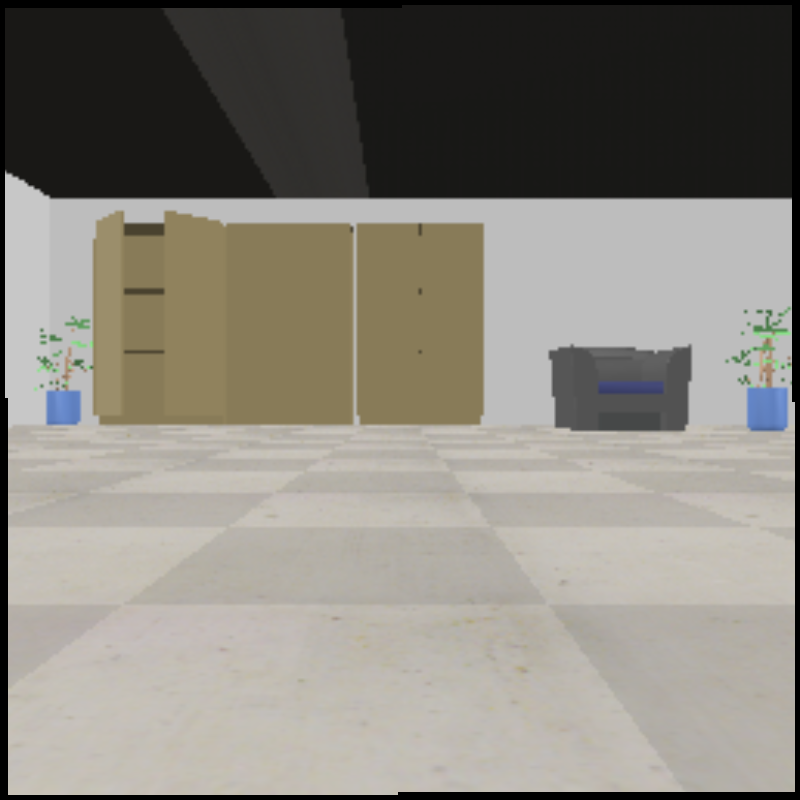

In [7]:
using Images

resolution, image_data = vision_data
image = imrotate(colorview(RGB, reshape(Float64.(image_data) / 255, 3, Int64.(resolution)...)), 3π/2)

imresize(image, 800, 800)

In [8]:
function get_current_position(robot)
    res, position = VREP.simx_get_object_position(robot.client_id,
                                                  robot.robot_handle,
                                                  -1,
                                                  VREP.simx_opmode_streaming)
    while res != VREP.simx_return_ok
        res, position = VREP.simx_get_object_position(robot.client_id,
                                                      robot.robot_handle,
                                                      -1,
                                                      VREP.simx_opmode_buffer)
    end
    return position
end

function get_current_orientation(robot)
    res, orientation = VREP.simx_get_object_orientation(robot.client_id,
                                                        robot.robot_handle,
                                                        -1,
                                                        VREP.simx_opmode_streaming)
    while res != VREP.simx_return_ok
        res, orientation = VREP.simx_get_object_orientation(robot.client_id,
                                                            robot.robot_handle,
                                                            -1,
                                                            VREP.simx_opmode_buffer)
    end
    return orientation
end

position = get_current_position(robot)

orientation = get_current_orientation(robot)

@show(position)

@show(orientation)

nothing

position = Float32[-2.0271423, -0.8250244, 0.13867742]
orientation = Float32[-6.887227e-5, -0.0020212135, -0.00049719686]


In [9]:
function set_right_velocity(robot, velocity)
    VREP.simx_set_joint_target_velocity(robot.client_id,
                                        robot.motors_handle[:right],
                                        velocity,
                                        VREP.simx_opmode_streaming)
    return nothing
end

function set_left_velocity(robot, velocity)
    VREP.simx_set_joint_target_velocity(robot.client_id,
                                        robot.motors_handle[:left],
                                        velocity,
                                        VREP.simx_opmode_streaming)
    return nothing
end

function set_velocity(robot, linear_velocity, angular_velocity)
    wheel_velocity = angular_velocity * (robot.robot_width / 2)
    left_velocity = (linear_velocity - wheel_velocity) / robot.wheel_radius
    right_velocity = (linear_velocity + wheel_velocity) / robot.wheel_radius
    set_left_velocity(robot, left_velocity)
    set_right_velocity(robot, right_velocity)
    return nothing
end

function stop(robot)
    set_velocity(robot, 0, 0)
    sleep(0.1)
    return nothing
end

p0 = get_current_position(robot)
a0 = get_current_orientation(robot)

@show(p0)
@show(a0)

set_velocity(robot, 0.1, 0)

sleep(5)

stop(robot)

p1 = get_current_position(robot)
a1 = get_current_orientation(robot)

@show(p1)
@show(a1)

nothing

p0 = Float32[-2.0271602, -0.82502615, 0.13867892]
a0 = Float32[-7.6393466e-5, -0.0020618178, -0.0004961093]
p1 = Float32[-1.4557617, -0.82534534, 0.13869557]
a1 = Float32[-6.542697e-5, -0.0015485769, -0.0005437005]


In [10]:
function reset_simulation(connection_address="127.0.0.1", connection_port=UInt16(19997))
    client_id = VREP.simx_start(connection_address, connection_port, true, true, 2000, 5)
    if client_id == -1
        error("Unable to connect to V-REP!")
    end
    VREP.simx_stop_simulation(client_id, VREP.simx_opmode_oneshot)
    println("Simulation stopped...")
    sleep(2.0)
    VREP.simx_start_simulation(client_id, VREP.simx_opmode_oneshot)
    println("Simulation started...")
    sleep(3.0)
    VREP.simx_finish(client_id)
end

reset_simulation()

robot = Robot()

p2 = get_current_position(robot)
a2 = get_current_orientation(robot)

@show(p0)
@show(p1)
@show(p2)

@show(a0)
@show(a1)
@show(a2)

nothing

Simulation stopped...
Simulation started...
Connected to remoteApi server.
Pioneer_p3dx_ultrasonicSensor1 connected.
Pioneer_p3dx_ultrasonicSensor2 connected.
Pioneer_p3dx_ultrasonicSensor3 connected.
Pioneer_p3dx_ultrasonicSensor4 connected.
Pioneer_p3dx_ultrasonicSensor5 connected.
Pioneer_p3dx_ultrasonicSensor6 connected.
Pioneer_p3dx_ultrasonicSensor7 connected.
Pioneer_p3dx_ultrasonicSensor8 connected.
Pioneer_p3dx_ultrasonicSensor9 connected.
Pioneer_p3dx_ultrasonicSensor10 connected.
Pioneer_p3dx_ultrasonicSensor11 connected.
Pioneer_p3dx_ultrasonicSensor12 connected.
Pioneer_p3dx_ultrasonicSensor13 connected.
Pioneer_p3dx_ultrasonicSensor14 connected.
Pioneer_p3dx_ultrasonicSensor15 connected.
Pioneer_p3dx_ultrasonicSensor16 connected.
Vision sensor connected.
Laser connected.
Left motor connected.
Right motor connected.
Robot connected.
p0 = Float32[-2.0271602, -0.82502615, 0.13867892]
p1 = Float32[-1.4557617, -0.82534534, 0.13869557]
p2 = Float32[-2.0253582, -0.8249918, 0.138